# Time delay-cosmography simulations

This notebook requires standard python libraries and the publicly available packages on github:

- lenstronomy (https://github.com/sibirrer/lenstronomy)
- fastell4py (https://github.com/sibirrer/fastell4py), based on the original fastell fortran code (by Barkana)

The packages are based on Birrer, Amara & Refregier 2015 and an official release is planned with Birrer et al. (in prep)
Installation for each package can be found on the github page.
WARNING: a proper installation of fastell4py   needs a fortran compiler.
This notebook has been tested with lenstronomy 0.1.0.

For further information, please get in touch with the author of this notebook, Simon Birrer: sibirrer@gmail.com

In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel

## simulation choices

/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10


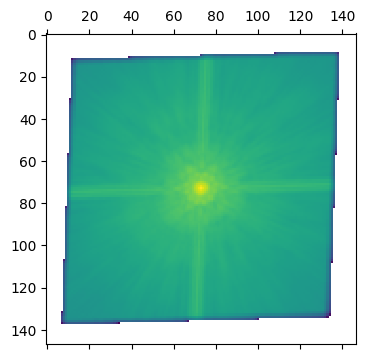

In [2]:
# import main simulation class of lenstronomy
from lenstronomy.SimulationAPI.simulations import Simulation
SimAPI = Simulation()

# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.5
z_source = 1.5
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


# import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Data/PSF_TinyTim/psf_example.fits')
kernel = pyfits.getdata(psf_filename)

plt.matshow(np.log10(kernel))
plt.show()

    
# data specifics
sigma_bkg = .01  #  background noise per pixel (Gaussian)
exp_time = 100.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 100  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91

# initial input simulation

# generate the coordinate grid and image properties
data_class = SimAPI.data_configure(numPix, deltaPix, exp_time, sigma_bkg)
# generate the psf variables
psf_class = SimAPI.psf_configure(psf_type=psf_type, fwhm=fwhm, kernelsize=kernel_size, deltaPix=deltaPix, truncate=3, kernel=kernel)



/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/ipykernel/__main__.py:73: RuntimeWarning: invalid value encountered in log10


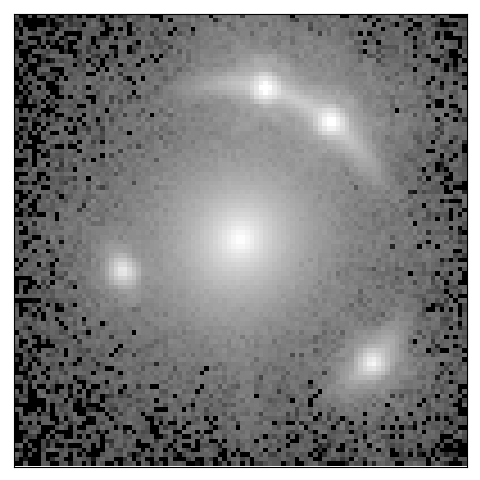

In [3]:
# lensing quantities
kwargs_shear = {'e1': 0.0, 'e2': -0.1}  # shear values to the source plane
kwargs_spemd = {'theta_E': 1.66, 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'q': .8, 'phi_G': 0.}  # parameters of the deflector lens model

# the lens model is a supperposition of an elliptical lens model with external shear
lens_model_list = ['SPEMD', 'SHEAR']
kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

# choice of source type
source_type = 'SERSIC'  # 'SERSIC' or 'SHAPELETS'

source_x = 0.2
source_y = 0


# Sersic parameters in the initial simulation
kwargs_sersic_source = {'I0_sersic': 4, 'R_sersic': 0.05, 'n_sersic': 1, 'q': .8, 'phi_G': 0.5, 'center_x': source_x, 'center_y': source_y}
kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}

source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic_source]
source_model_class = LightModel(light_model_list=source_model_list)


# lens light model
kwargs_sersic_lens = {'I0_sersic': 20, 'R_sersic': 0.2, 'n_sersic': 2, 'q': .9, 'phi_G': 0.9, 'center_x': 0.0, 'center_y': 0}
lens_light_model_list = ['SERSIC_ELLIPSE']
kwargs_lens_light = [kwargs_sersic_lens]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.findBrightImage(source_x, source_y, kwargs_lens, numImages=4,
                                                      min_distance=deltaPix, search_window=numPix * deltaPix)
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
kwargs_ps = [{'ra_image': x_image, 'dec_image': y_image,
                           'point_amp': np.abs(mag)*100}]  # quasar point source position in the source plane and intrinsic brightness
point_source_list = ['LENSED_POSITION']
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

kwargs_numerics = {'subgrid_res': 1, 'psf_subgrid': False}

imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                lens_light_model_class,
                                point_source_class, kwargs_numerics=kwargs_numerics)
image_sim = SimAPI.simulate(imageModel, kwargs_lens, kwargs_source,
                                         kwargs_lens_light, kwargs_ps)


# generate image
image_sim = SimAPI.simulate(imageModel, kwargs_lens, kwargs_source,
                                         kwargs_lens_light, kwargs_ps)# update kwargs_data with the newly generated mock
data_class.update_data(image_sim)


kwargs_model = {'lens_model_list': lens_model_list, 
                 'lens_light_model_list': lens_light_model_list,
                 'source_light_model_list': source_model_list,
                'point_source_model_list': point_source_list
                 }

# display the initial simulated image
cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 2

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)
ax = axes
im = ax.matshow(np.log10(image_sim), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)
plt.show()

In [4]:
from lenstronomy.Analysis.lens_properties import LensProp
lensProp = LensProp(z_lens, z_source, kwargs_model, cosmo=cosmo)

# time delays
dt_days = lensProp.time_delays(kwargs_lens, kwargs_ps, kappa_ext=0)
print("the time delays for the images at position ", kwargs_ps[0]['ra_image'], kwargs_ps[0]['dec_image'], "are: ",dt_days)


# kinematics

R_slit = 1. # slit length in arcsec
dR_slit = 1.  # slit width in arcsec
psf_fwhm = 0.7
num_evaluate = 1000  # numerical ray-shooting, should converge -> infinity
kwargs_aperture = {'length': R_slit, 'width': dR_slit, 'center_ra': 0.05, 'center_dec': 0, 'angle': 0}
anisotropy_model = 'OsipkovMerritt'
aperture_type = 'slit'

r_ani = 1.
r_eff = 0.2
kwargs_anisotropy = {'r_ani': r_ani}

vel_disp = lensProp.velocity_disperson_numerical(kwargs_lens, kwargs_lens_light, kwargs_anisotropy, kwargs_aperture, psf_fwhm, aperture_type, anisotropy_model, MGE_light=True, MGE_mass=True, r_eff=r_eff)
print(vel_disp, 'velocity dispersion in km/s')

('the time delays for the images at position ', array([ 0.27669797,  0.99592927,  1.4596848 , -1.29583094]), array([ 1.66741547,  1.29702629, -1.36284606, -0.34513872]), 'are: ', array([-135.48467494, -134.71126311, -165.3661448 ,  -86.01104926]))
(array([ 291.14098759]), 'velocity dispersion in km/s')


## Model and parameter choices

In [5]:
# lens model choicers
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({}) 
#kwargs_lens_init.append({'theta_E': 1.5, 'gamma': 2, 'center_x': 0.0, 'center_y': 0, 'q': 1., 'phi_G': 0.})
kwargs_lens_init.append(kwargs_spemd)
kwargs_lens_sigma.append({'theta_E_sigma': .1, 'ellipse_sigma':0.1, 'gamma_sigma': 0.2, 'center_x_sigma': 0.1, 'center_y_sigma': 0.1})
kwargs_lower_lens.append({'theta_E': 0.01,'q': .5, 'gamma': 1.5, 'phi_G': 0., 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10,'q': .5, 'gamma': 2.5, 'phi_G': 0., 'center_x': 10, 'center_y': 10})

fixed_lens.append({})
#kwargs_lens_init.append({'e1': 0.0, 'e2': 0.0})
kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'shear_sigma': 0.1})
kwargs_lower_lens.append({'e1': -0.2, 'e2': -0.2})
kwargs_upper_lens.append({'e1': 0.2, 'e2': 0.2})


# lens light model choices
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []

fixed_lens_light.append({})
#kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_lens_light_init.append(kwargs_sersic_lens)
kwargs_lens_light_sigma.append({'n_sersic_sigma': 0.5, 'R_sersic_sigma': 0.2, 'ellipse_sigma': 0.1, 'center_x_sigma': 0.1, 'center_y_sigma': 0.1})
kwargs_lower_lens_light.append({'q': .5, 'phi_G': 0, 'R_sersic': 0.01, 'n_sersic': 0.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens_light.append({'q': .5, 'phi_G': 0, 'R_sersic': 10, 'n_sersic': 8, 'center_x': 10, 'center_y': 10})


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []

fixed_source.append({})
#kwargs_source_init.append({'R_sersic': 0.1, 'n_sersic': 1, 'q': 1., 'phi_G': 0., 'center_x': 0, 'center_y': 0})
kwargs_source_init.append(kwargs_sersic_source)
kwargs_source_sigma.append({'n_sersic_sigma': 0.5, 'R_sersic_sigma': 0.1, 'ellipse_sigma': 0.1, 'center_x_sigma': 0.1, 'center_y_sigma': 0.1})
kwargs_lower_source.append({'q': .5, 'phi_G': 0, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'q': .5, 'phi_G': 0, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})


fixed_ps = [{}]
kwargs_ps_init = kwargs_ps
kwargs_ps_sigma = [{'pos_sigma': 0.01, 'pos_sigma': 0.01}]
kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(x_image)), 'dec_image': -10 * np.ones(len(y_image))}]
kwargs_upper_ps = [{'ra_image': 10* np.ones(len(x_image)), 'dec_image': 10 * np.ones(len(y_image))}]

kwargs_fixed = [fixed_lens, fixed_source, fixed_lens_light, fixed_ps]
kwargs_init = [kwargs_lens_init, kwargs_source_init, kwargs_lens_light_init, kwargs_ps_init]
kwargs_sigma = [kwargs_lens_sigma, kwargs_source_sigma, kwargs_lens_light_sigma, kwargs_ps_sigma]
kwargs_lower = [kwargs_lower_lens, kwargs_lower_source, kwargs_lower_lens_light, kwargs_lower_ps]
kwargs_upper = [kwargs_upper_lens, kwargs_upper_source, kwargs_upper_lens_light, kwargs_upper_ps]



In [6]:


# numerical options and fitting sequences

num_source_model = len(source_model_list)

kwargs_constraints = {'joint_center_lens_light': False,
                              'joint_center_source_light': False,
                              'num_point_source_list': [4],
                              'additional_images_list': [False],
                              'fix_to_point_source_list': [True] * num_source_model,
                              'image_plane_source_list': [False] * num_source_model,
                              'solver': True,
                              'solver_type': 'PROFILE_SHEAR',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                              }

kwargs_likelihood = {'check_bounds': True,
                             'force_no_add_image': False,
                             'source_marg': False,
                             'point_source_likelihood': False,
                             'position_uncertainty': 0.004,
                             'check_solver': True,
                             'solver_tolerance': 0.001
                             }
kwargs_fixed = [[{}, {}], [{}], [{}], [{}]]
kwargs_data = data_class.constructor_kwargs()
kwargs_psf = psf_class.constructor_kwargs()
image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
multi_band_list = [image_band]
kwargs_init = [kwargs_lens, kwargs_source, kwargs_lens_light, kwargs_ps]

from lenstronomy.Workflow.fitting_sequence import FittingSequence

mpi = False  # MPI possible, but not supported through that notebook.

kwargs_params = [kwargs_init, kwargs_sigma, kwargs_fixed, kwargs_lower, kwargs_upper]

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [
        {'fitting_routine': 'PSO', 'mpi': False, 'sigma_scale': 1., 'n_particles': 200,
         'n_iterations': 200},
        {'fitting_routine': 'MCMC', 'n_burn': 10, 'n_run': 10, 'walkerRatio': 10, 'mpi': False,
         'sigma_scale': .1}]

start_time = time.time()
lens_result, source_result, lens_light_result, ps_result, chain_list, param_list, samples_mcmc, param_mcmc, dist_mcmc = fitting_seq.fit_sequence(fitting_kwargs_list)
end_time = time.time()
print(end_time - start_time, 'total time needed for computation')
print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')

Computing the PSO ...


/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/sibirrer/Library/Python/2.7/lib/python/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
converged after 190 iterations!
best fit found:  -5170.75621032 [  2.13245942e+00   1.13382582e-01   1.08293017e+00   5.54832251e-02
   5.94547937e-02   8.90674797e-02  -4.30044900e-04  -1.92754105e-04
   2.07990007e+00   2.00751311e-01  -1.29550782e-02   5.13588425e-02
   2.76294201e-01   9.95723068e-01   1.46018753e+00  -1.29569819e+00
   1.66778510e+00   1.29707688e+00  -1.36256322e+00  -3.45527549e-01]
(-1.0363275298766863, 'reduced X^2 of best position')
(9979, 'effective number of data points')
([{'theta_E': 1.6570869911053678, 'q': 0.78596724522698336, 'center_x': 0.0023765723865856142, 'center_y': 0.0015640081116088953, 'phi_G': 0.0020587803083967743, 'gamma': 2.1324594182734282}, {'e1': -0.011143404306352661, 'e2': -0.11283365840796268}], 'lens result')
([{'q': 0.80654075320954421, 'I0_sersic': 1, 'n_sersic': 1.0829301664147466, 'center_x': 0.22818723803312368, 'center_y': 0.0018972728602682926, 'phi_G': 0.4910

## analyse model output

('reduced chi^^ = ', 1.4787522934894723)


/Users/sibirrer/Cosmology/Software/lenstronomy/lenstronomy/Plots/output_plots.py:220: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


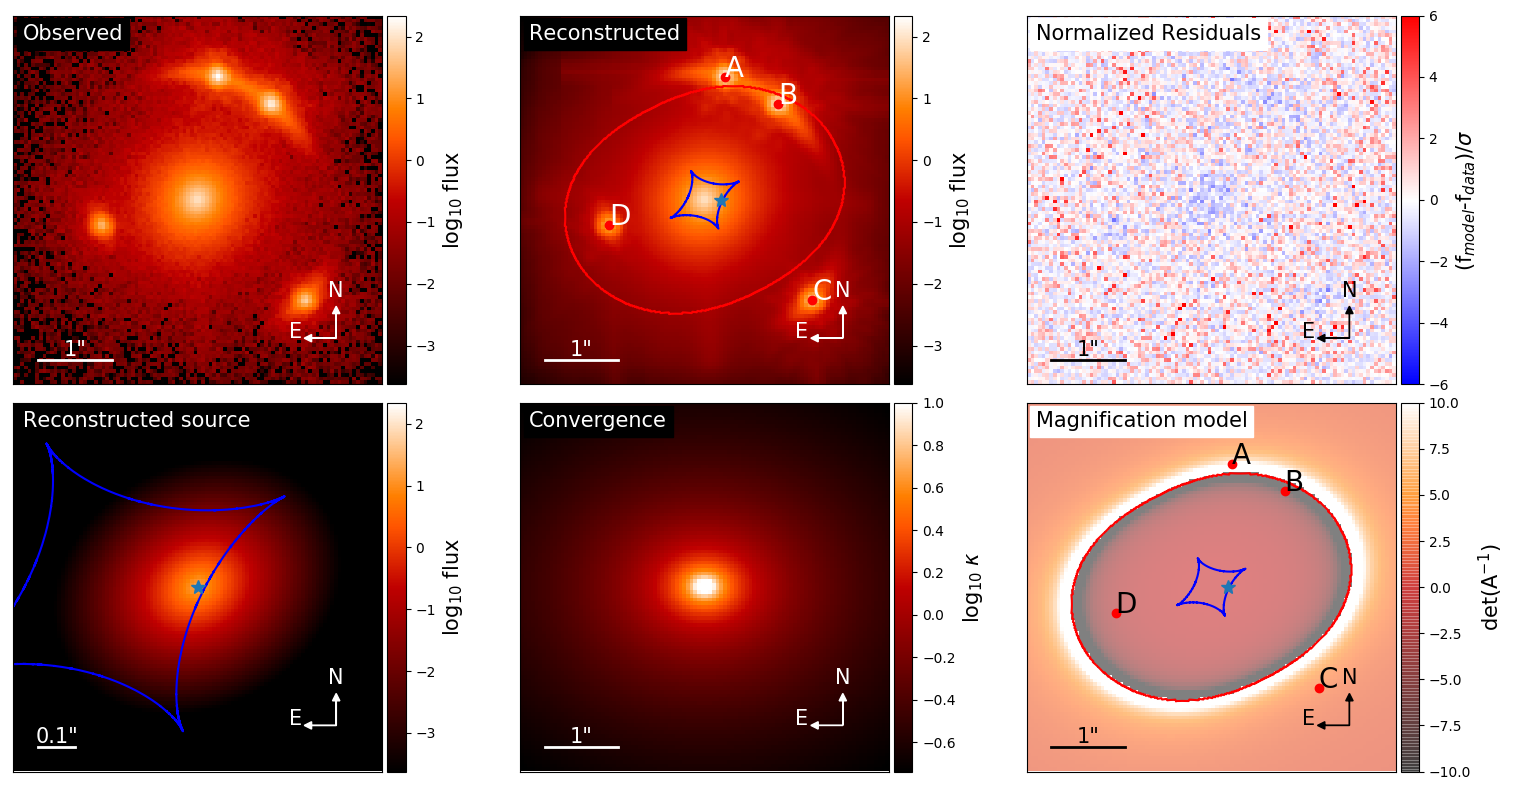

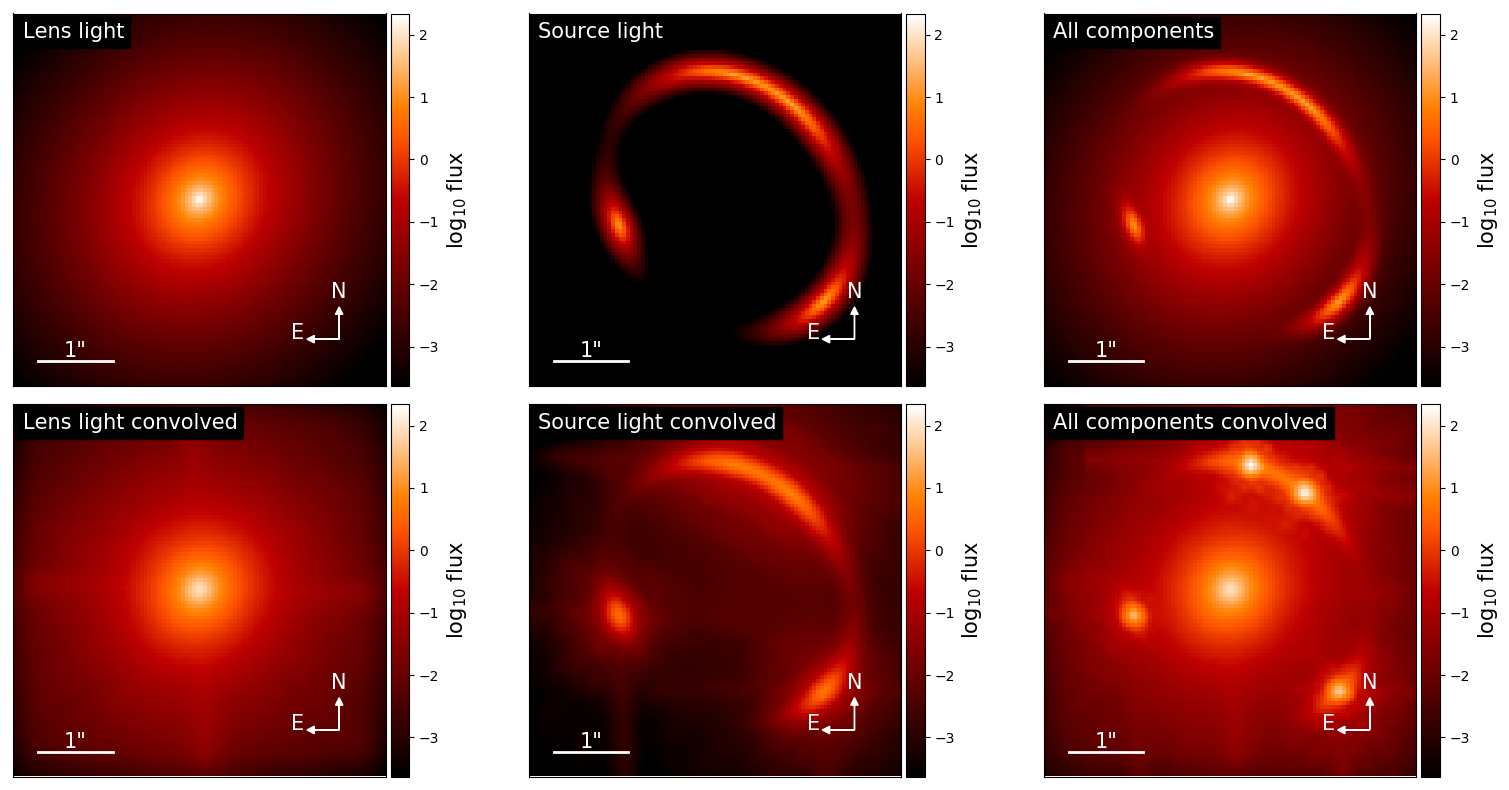

[{'theta_E': 1.6570869911053678, 'q': 0.78596724522698336, 'center_x': 0.0023765723865856142, 'center_y': 0.0015640081116088953, 'phi_G': 0.0020587803083967743, 'gamma': 2.1324594182734282}, {'e1': -0.011143404306352661, 'e2': -0.11283365840796268}] [{'q': 0.80654075320954421, 'I0_sersic': 3.8571448390027476, 'n_sersic': 1.0829301664147466, 'center_x': 0.22818723803312368, 'center_y': 0.0018972728602682926, 'phi_G': 0.49109976953684664, 'R_sersic': 0.055483225093374604}] [{'q': 0.89939370781996542, 'I0_sersic': 19.295601481987894, 'n_sersic': 2.0799000713700289, 'center_x': -0.00043004489973080796, 'center_y': -0.00019275410496871957, 'phi_G': 0.90894401961503934, 'R_sersic': 0.20075131128793366}] [{'point_amp': array([ 1257.84800768,  1249.15648845,   397.47955052,   228.75802357]), 'ra_image': array([ 0.2762942 ,  0.99572307,  1.46018753, -1.29569819]), 'dec_image': array([ 1.6677851 ,  1.29707688, -1.36256322, -0.34552755])}]


/Users/sibirrer/Cosmology/Software/lenstronomy/lenstronomy/Plots/output_plots.py:499: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data - model), origin='lower', vmin=v_min, vmax=v_max,


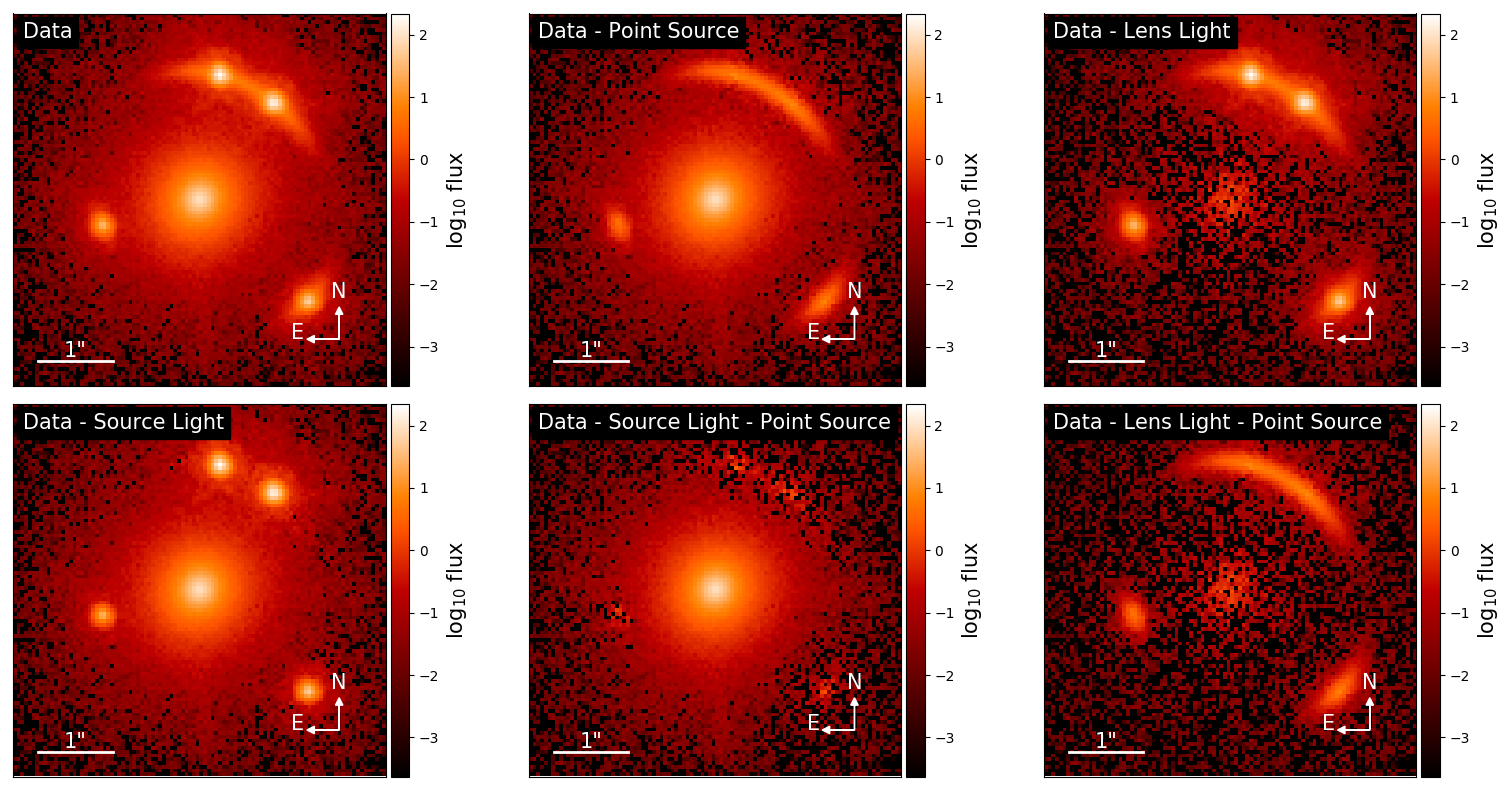

In [10]:
import lenstronomy.Plots.output_plots as out_plot

from lenstronomy.Plots.output_plots import LensModelPlot

lensPlot = LensModelPlot(kwargs_data, kwargs_psf, kwargs_numerics, kwargs_model, lens_result, source_result,
                             lens_light_result, ps_result, arrow_size=0.02, cmap_string="gist_heat", high_res=5)
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.data_plot(ax=axes[0,0])
lensPlot.model_plot(ax=axes[0,1])
lensPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
lensPlot.source_plot(ax=axes[1, 0],convolution=False, deltaPix_source=0.01, numPix=100)
lensPlot.convergence_plot(ax=axes[1, 1], v_max=1)
lensPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
lensPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
lensPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
lensPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
lensPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
lensPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print lens_result, source_result, lens_light_result, ps_result
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

lensPlot.subtract_from_data_plot(ax=axes[0,0], text='Data')
lensPlot.subtract_from_data_plot(ax=axes[0,1], text='Data - Point Source', point_source_add=True)
lensPlot.subtract_from_data_plot(ax=axes[0,2], text='Data - Lens Light', lens_light_add=True)
lensPlot.subtract_from_data_plot(ax=axes[1,0], text='Data - Source Light', source_add=True)
lensPlot.subtract_from_data_plot(ax=axes[1,1], text='Data - Source Light - Point Source', source_add=True, point_source_add=True)
lensPlot.subtract_from_data_plot(ax=axes[1,2], text='Data - Lens Light - Point Source', lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()


In [ ]:
print "number of non-linear parameters in the MCMC process: ", len(param_mcmc)
print "parameters in order: ", param_mcmc
print "number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0]
import corner


# import the parameter handling class #
from lenstronomy.Workflow.parameters import Param
# make instance of parameter class with given model options, constraints and fixed parameters #
param = Param(kwargs_model, kwargs_constraints, fixed_lens, fixed_source,
                 fixed_lens_light, fixed_ps, kwargs_lens_init=kwargs_lens)
# the number of non-linear parameters and their names #
num_param, param_list = param.num_param()

from lenstronomy.Analysis.lens_analysis import LensAnalysis
lensAnalysis = LensAnalysis(kwargs_model)

mcmc_new_list = []
labels_new = [r"$\phi_{Fermat}$", r"$\gamma$", r"$\phi_{ext}$", r"$\gamma_{ext}$"]
for i in range(len(samples_mcmc)):
    # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
    kwargs_lens_out, kwargs_light_source_out, kwargs_light_lens_out, kwargs_ps_out = param.getParams(samples_mcmc[i])
    fermat_pot = lensAnalysis.fermat_potential(kwargs_lens_out, kwargs_ps_out)
    delta_fermat_12 = fermat_pot[0] - fermat_pot[2]
    gamma = kwargs_lens_out[0]['gamma']
    phi_ext, gamma_ext = lensAnalysis.LensModel.external_shear(kwargs_lens_out)
    mcmc_new_list.append([delta_fermat_12, gamma, phi_ext, gamma_ext])


plot = corner.corner(mcmc_new_list, labels=labels_new, show_titles=True)

number of non-linear parameters in the MCMC process:  20
parameters in order:  ['gamma_lens', 'gamma_ext', 'n_sersic_source_light', 'R_sersic_source_light', 'e1_source_light', 'e2_source_light', 'center_x_lens_light', 'center_y_lens_light', 'n_sersic_lens_light', 'R_sersic_lens_light', 'e1_lens_light', 'e2_lens_light', 'ra_image', 'ra_image', 'ra_image', 'ra_image', 'dec_image', 'dec_image', 'dec_image', 'dec_image']
number of evaluations in the MCMC process:  2000
